- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) with edits by [Rik Henson](https://www.mrc-cbu.cam.ac.uk/people/rik.henson/)
- **Date:** August 2026  
- **conda environment**: [mri conda environment](../mri_environment.yml).

# fMRI Data Analysis: Group-Level Analysis

Once you have beta maps for conditions (or contrast maps for contrasts) from all subjects, you can perform group-level statistics. Importantly, all subject first-level results need to be in common space, e.g., MNI, to perform voxel-wise group analyses. 

Group-level analysis allows you to make inferences about the population, rather than individual subjects, by assessing common activations across participants. Common statistical methods for group-level analysis include one-sample, paired t-tests, or more complex ANOVA models.

In this tutorial, **we will illustrate an ANOVA** in which we include:
- **9 contrast** (one for each of the 9 experimental conditions, averaged across runs), 
- **16 additional regressors** to account for between-subject variance. 

This corresponds to a ***repeated-measures ANOVA***, under the assumption that the pooled error is spherical *(see [Rik's Stats tutorial](https://github.com/RikHenson/Stats4Imaging) section on ANOVA for the importance of this)*. 

Here is a recommended viewing to help better understand the principles of the group-level analysis:

In [1]:
from IPython.display import display, HTML

display(HTML('''
<div style="width: 1200px; margin: 0; display: flex; justify-content: space-around;">
    <div style="text-align: center;">
        <h3><a href="https://www.youtube.com/embed/__cOYPifDWk">Group-Level Analysis (7 min)</a></h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/__cOYPifDWk" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
</div>
'''))


---------------

**Table of contents**    
1. Import required packages and set up some stuff    
2. Retrieve First-Level results    
3. Displaying subject Effects-Of-Interest z-maps    
4. Specify the second-level model    
4.1. Design matrix for 3x3 repeated-measures ANOVA   
4.2. Model specification and fit Contrasts  
4.3. Contrasts   
5. Computing contrasts and plotting result maps    
5.1. Faces > Scrambled   
5.2. Famous > Unfamiliar  
5.3. Stimulus x Immediate Repetition interaction  
5.4. FWE correction using non-parametric permutation testing    
6. Summary results  
6.1. Using atlasreader package    
6.2. Nilearn's report   

-----
## Import required packages and set up some stuff

In [2]:
import os
import glob # to search for files using regex

import pandas as pd # for data manipulation
import numpy as np # for numerical operations

from bids import BIDSLayout # to fetch data from BIDS-compliant datasets

import matplotlib.pyplot as plt # for basic plotting

import nibabel as nib # NiBabel, to read and write neuroimaging data, https://nipy.org/nibabel/

# Nilearn modules, for the analysis of brain volumes, plotting, etc., https://nilearn.github.io/
from nilearn.plotting import plot_glass_brain, plot_design_matrix, plot_contrast_matrix, plot_stat_map, view_img, view_img_on_surf
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.datasets import load_mni152_template
from nilearn.glm.second_level import non_parametric_inference

from atlasreader import create_output # For generating result tables https://github.com/miykael/atlasreader

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



/imaging/correia/da05/conda/env/mriworkshops/lib/python3.11/site-packages/atlasreader/atlasreader.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [3]:
# MNI152 template will be used as a backgound for plotting results
mni152_template = load_mni152_template()

## Retrieve First-Level results

For the group analysis, we will use the single-condition contrast estimate (beta estimate) maps for all nine conditions. Because we saved the results in BIDS format, we can us PyBIDS to retrieve the subject-level results. 

In [4]:
# --- Set up the paths to the data and results folders
fmri_data_dir = '../example_data/FaceRecognition/data' # data in BIDS format
fmri_results_dir = '../example_data/FaceRecognition/results' # results in BIDS format

fmri_group_dir = os.path.join(fmri_results_dir, 'group-level') # where group results will go
os.makedirs(fmri_group_dir, exist_ok=True)

# --- Set up the BIDS layout
layout = BIDSLayout(fmri_data_dir, derivatives = True)

# Attach the results folder to the layout. It must complay with BIDS standards. 
# And must include dataset_description.json file!
layout.add_derivatives(os.path.join(fmri_results_dir, "first-level"))

## Displaying subject Effects-Of-Interest z-maps

To check how the first-level results look overall, it is helpful to display effects-of-interest for all subjects. 

In [5]:
eoi_maps = layout.get(desc='EffectsOfInterest', extension='.nii.gz', return_type='file')
print(*eoi_maps, sep="\n")

/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-01/sub-01_ses-mri_task-facerecognition_desc-EffectsOfInterest_z.nii.gz
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-02/sub-02_ses-mri_task-facerecognition_desc-EffectsOfInterest_z.nii.gz
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-03/sub-03_ses-mri_task-facerecognition_desc-EffectsOfInterest_z.nii.gz
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-04/sub-04_ses-mri_task-facerecognition_desc-EffectsOfInterest_z.nii.gz
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-05/sub-05_ses-mri_task-facerecognition_desc-EffectsOfInterest_z.nii.gz
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-06/

Text(0.5, 0.98, 'Effects of interest, unthresholded z-maps')

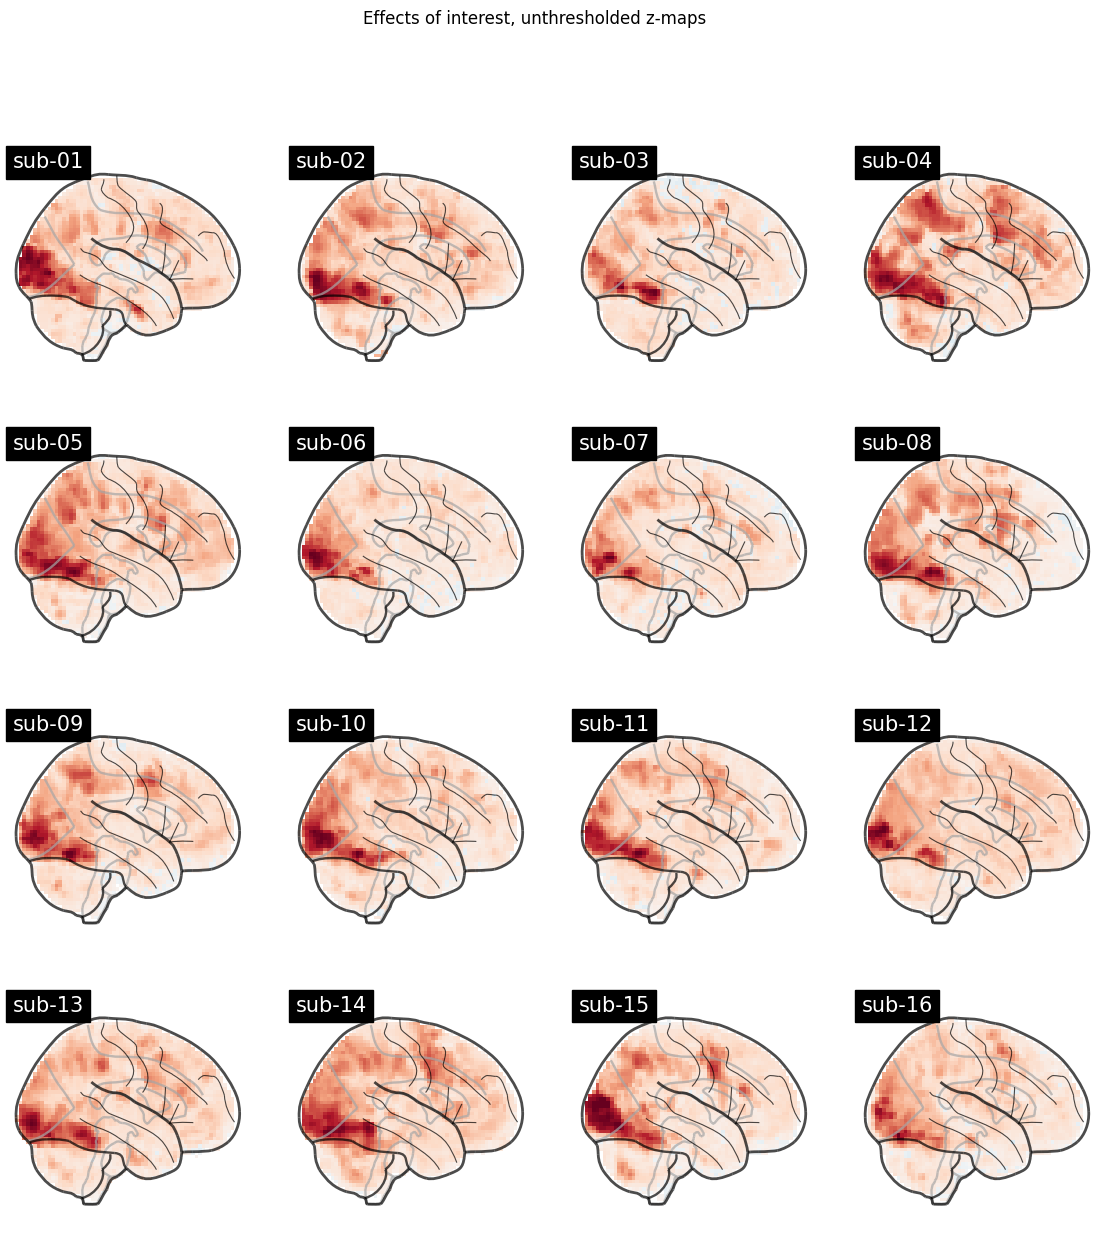

In [6]:
subjects = layout.get_subjects()

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 14))

for i, stat_map in enumerate(eoi_maps):
    plot_glass_brain(
      stat_map,
      title = 'sub-' + subjects[i],
      axes = axes[int(i / 4), int(i % 4)],
      plot_abs = False, 
      display_mode='x',
      colorbar=False
    )
fig.suptitle('Effects of interest' + ', unthresholded z-maps')

## Specify the second-level model

At the group-level analysis, we also use a GLM. The **outcome variable** is the beta/contrast estimate from each subject, and the **predictor variables** typically include group-level factors such as experimental conditions, subject-specific regressors (in repeated-measures designs), group-specific regressors (in between-subject designs), and subject-specific covariates (e.g., age, gender, or behavioural scores).

One approach is to obtain the **contrast of interest maps** (e.g. Faces > Scrambled) at the subject-level, and take these to the group-level **one-sample t-test**, i.e, testing whether those contrasts are significantly above or below zero when averaged across participants. This is called the **"partitioned error" or "summary statistic" approach**. With this approach, one has to estimate a new second-level model for each contrast of interest.

Alternatively, at the subject level, you can compute **beta maps for each condition** (e.g., Faces, Scrambled, etc.), average across runs, and take these to the group level. This allows you to run a **full ANOVA model across all conditions** (e.g., 3 × 3 design with our 9 conditions). This is called the **"pooled error" approach**. It can be more powerful, and simpler, because all contrasts can be tested within a single model. However, it makes stronger assumptions about the sphericity of the error, which may be violated, which is why the above "partitioned error" approach (one-sample t-test) is generally safer. See [Rik's stats notebook](https://github.com/RikHenson/Stats4Imaging) for more information.

Below we will perform the second approach - 3x3 ANOVA.

### Design matrix for 3x3 repeated-measures ANOVA

In this example, the design matrix we generate will incorporate both **within-subject (conditions)** and **between-subject (subjects)** factors. Each row in the design matrix corresponds to a specific observation, which in this case is a beta estimate from a given condition and subject, while each column represents a predictor variable.

The number of rows in the design matrix must match the number of first-level result files that will be entered into the second-level model. **The order of the rows in the design matrix must match the order of the provided files!**


In [7]:
# Specify which conditions to include in the analysis and retrieve their effect files from the first-level results.
conditions = ['IniFF', 'ImmFF', 'DelFF', 'IniUF', 'ImmUF', 'DelUF', 'IniSF', 'ImmSF', 'DelSF']

effect_files = layout.get(desc=conditions, suffix='effect', extension='.nii.gz', return_type='filename')

# print to see if it found what we expexted
print(f"Found {len(effect_files)} effect files:")
print(*effect_files[0:10], sep="\n")

Found 144 effect files:
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-01/sub-01_ses-mri_task-facerecognition_desc-DelFF_effect.nii.gz
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-01/sub-01_ses-mri_task-facerecognition_desc-DelSF_effect.nii.gz
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-01/sub-01_ses-mri_task-facerecognition_desc-DelUF_effect.nii.gz
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-01/sub-01_ses-mri_task-facerecognition_desc-ImmFF_effect.nii.gz
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-01/sub-01_ses-mri_task-facerecognition_desc-ImmSF_effect.nii.gz
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/results/first-level/sub-01/sub-01_ses-

Note we have reordered the conditions so that in our 3 × 3 design, the “stimulus” factor (Famous Face, Unfamiliar Face, Scrambled Face) changes most slowly, while the “presentation” factor (Initial, Immediate Repeat, Delayed Repeat) cycles fastest. This ordering makes it easier to interpret the design matrix and the contrasts.

Text(0, 0.5, 'stat maps')

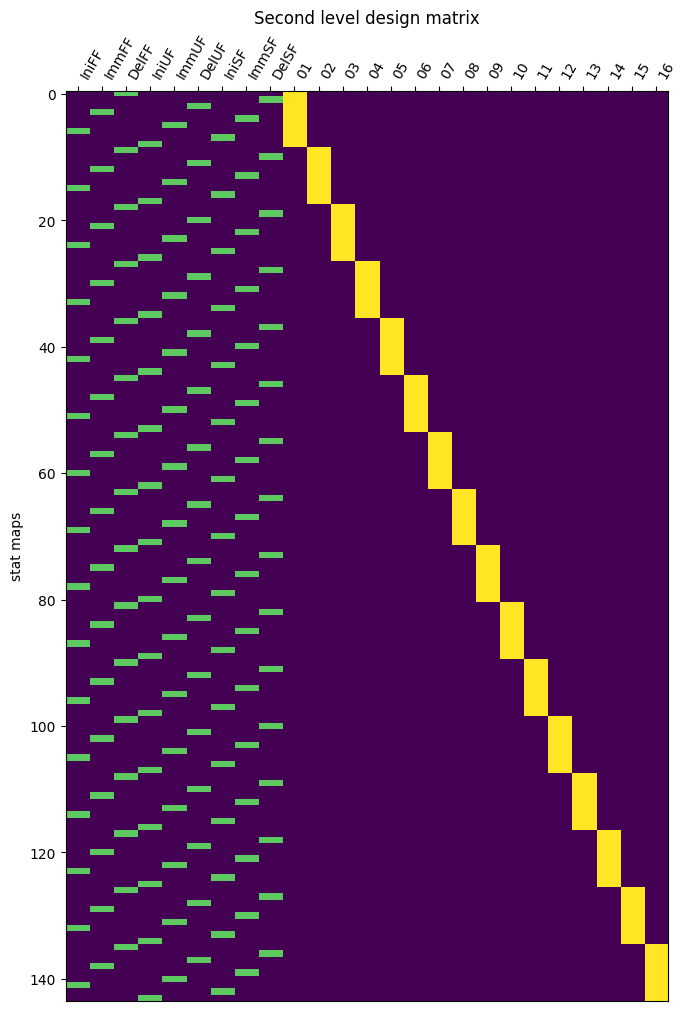

In [8]:
# Create an empty DataFrame
df = pd.DataFrame(columns=conditions + subjects)

# Populate the DataFrame with 0s and 1s
for i, condition in enumerate(conditions):
    # Filter files based on condition
    condition_files = [1 if condition in file else 0 for file in effect_files]
    # Add a column for the condition
    df[condition] = condition_files

# Populate the DataFrame with 0s and 1s for subjects
for i, subject in enumerate(subjects):
    # Filter files based on subject
    subject_files = [1 if f"sub-{subject}" in file else 0 for file in effect_files]
    # Add a column for the subject
    df[subject] = subject_files

# Display the design matrix
design_matrix = df
ax = plot_design_matrix(design_matrix)
ax.set_title("Second level design matrix", fontsize=12)
ax.set_ylabel("stat maps")

The first 9 columns of the design matrix represent the **mean response for each experimental condition**. The remaining 16 columns represent the **mean response for each subject**. While these subject-specific columns are not of direct interest, including them allows us to remove between-subject variance. This, in turn, can improve the statistical sensitivity of contrasts over the first 9 columns by reducing residual error.

### Model specification and fit

In [9]:
# specify
second_level_model = SecondLevelModel() 

# fit
second_level_model = second_level_model.fit(
  effect_files, 
  design_matrix = design_matrix
  )

### Contrasts

We can specify some contrasts that might be of interest. The first two are T-contrasts (one row), the last is an F-contrast (more than one row):

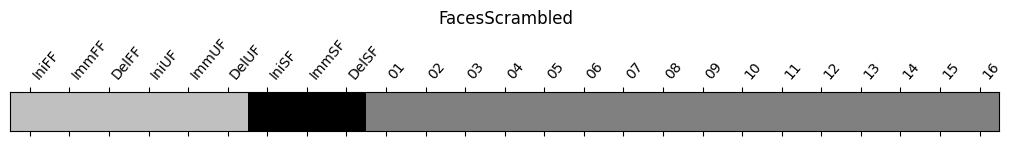

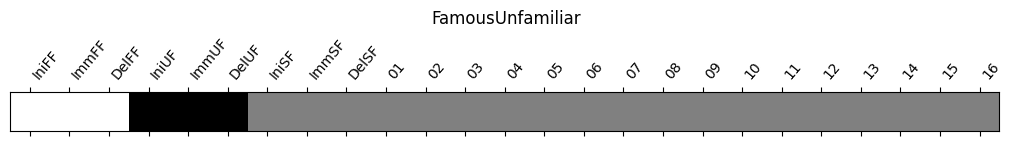

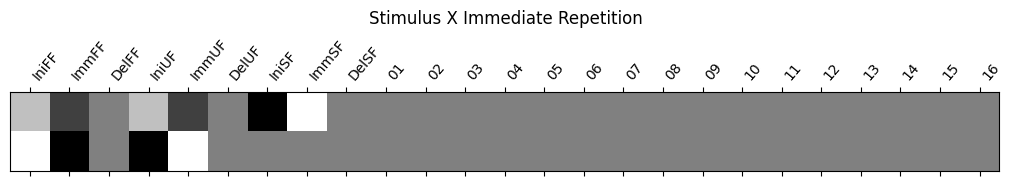

In [10]:
n_columns = design_matrix.shape[1]
n_conditions = len(conditions)

contrasts = {
  'FacesScrambled':   np.pad([1/6,  1/6,  1/6,  1/6,  1/6,  1/6, -1/3, -1/3, -1/3], (0, n_columns - n_conditions), 'constant'),
  'FamousUnfamiliar': np.pad([1/3,  1/3,  1/3, -1/3, -1/3, -1/3,    0,    0,    0], (0, n_columns - n_conditions), 'constant'),
  'Stimulus X Immediate Repetition': np.array([np.pad(np.kron([1/2, 1/2, -1], [1, -1, 0]), (0, n_columns - n_conditions), 'constant'),
                                     np.pad(np.kron([1,   -1,   0], [1, -1, 0]), (0, n_columns - n_conditions), 'constant')])
}

for contrast_id, contrast_val in contrasts.items():
    plot_contrast_matrix(contrast_val, design_matrix=design_matrix, colorbar=False)
    plt.suptitle(contrast_id)


Note that there is no particular scientific reason for the specific F-contrast interaction above, other than to demonstrate how to construct such contrasts.

## Computing contrasts and plotting result maps

We could then loop through every contrast like below, using the same threshold:
```python
for contrast_id, contrast_val in contrasts.items():
    print(f"\tcontrast id: {contrast_id}")
    z_map = second_level_model.compute_contrast(contrast_val, output_type="z_score")

    thresholded_map, threshold = threshold_stats_img(
        z_map, 
        alpha = 0.001, 
        height_control = None, 
        two_sided = True)
    
    plot_stat_map(
        thresholded_map, 
        threshold = threshold, 
        bg_img = mni152_template,
        display_mode="ortho",
        black_bg = True,
        cmap = 'hot', 
        title = contrast_id)  
    
    fig = plt.gcf()
    fig.set_size_inches(10,3)
    plt.show()
```
but let's look at each contrast separately. 

### Faces > Scrambled

Here we will use one-tailed Bonferroni (FWE) correction. 

In [11]:
# get the z-maps for the contrast
z_map = second_level_model.compute_contrast(contrasts['FacesScrambled'], output_type='z_score')

Bonferroni p<.05 threshold: 4.823


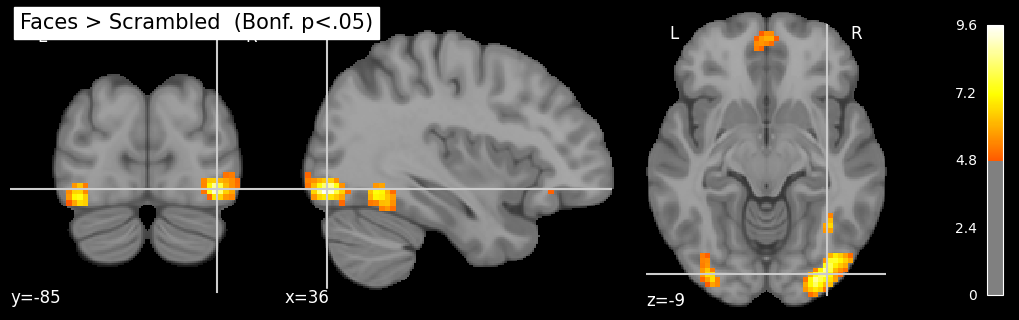

In [12]:
thresholded_map_bonf, threshold_bonf = threshold_stats_img(
  z_map, 
  alpha=0.05, 
  height_control='bonferroni', 
  two_sided=False)

print('Bonferroni p<.05 threshold: %.3f' % threshold_bonf)

plot_stat_map(
    thresholded_map_bonf, 
    bg_img = mni152_template,
    threshold=threshold_bonf,   
    display_mode = 'ortho',
    black_bg = True,
    cmap = 'hot',    
    title = 'Faces > Scrambled  (Bonf. p<.05)'
    )

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

In [13]:
# Interactive plotting
plot = view_img(
  thresholded_map_bonf, 
  bg_img=mni152_template, 
  threshold=threshold_bonf, 
  colorbar=True, 
  cmap = 'cold_hot',
  title='Faces > Scrambled  (Bonf. p<.05)'
  )

plot.open_in_browser()

/imaging/correia/da05/conda/env/mriworkshops/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


### Famous > Unfamiliar

This time we will use a one-tailed FDR correction:

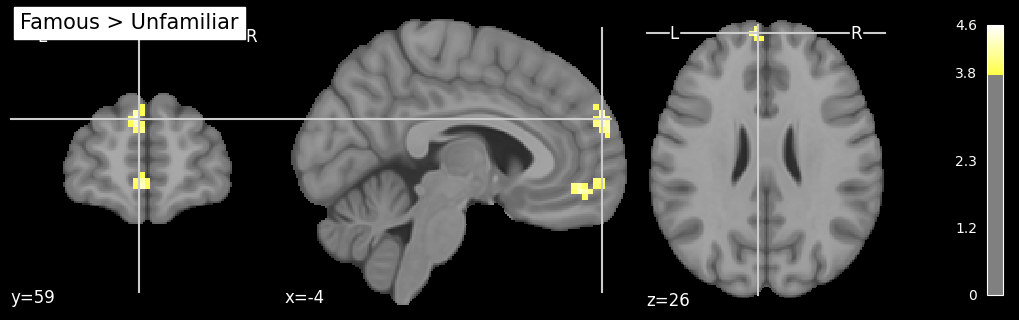

In [14]:
z_map = second_level_model.compute_contrast(contrasts['FamousUnfamiliar'], output_type="z_score")
thresholded_map, threshold = threshold_stats_img(
        z_map, 
        alpha = 0.05, 
        height_control = 'fdr', 
        two_sided = False)
plot_stat_map(
        thresholded_map, 
        threshold = threshold, 
        bg_img = mni152_template,
        display_mode="ortho",
        black_bg = True,
        cmap = 'hot', 
        title = 'Famous > Unfamiliar',
    )       
fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

We observe increased activity in medial prefrontal regions for famous faces, which participants likely recognised. This may reflect engagement of semantic memory or emotional processing.

### Stimulus x Immediate Repetition interaction

Finally, what about the interaction F-contrast we created, which asks whether the effect of repetition depends on whether the repeated stimulus is a face or scrambled face:

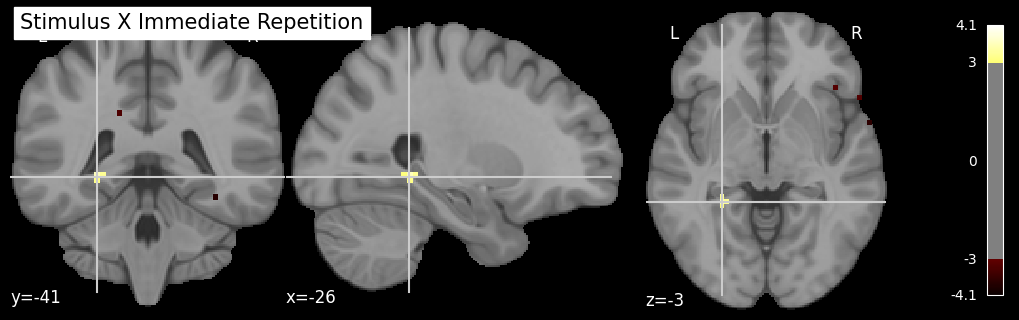

In [15]:
z_map = second_level_model.compute_contrast(contrasts['Stimulus X Immediate Repetition'], output_type="z_score") # Don't need stat_type="F" option?
thresholded_map, threshold = threshold_stats_img(
        z_map, 
        alpha = 0.001, 
        height_control = None,
        two_sided = True)
plot_stat_map(
        thresholded_map, 
        threshold = threshold, 
        bg_img = mni152_template,
        display_mode="ortho",
        black_bg = True,
        cmap = 'hot', 
        title = 'Stimulus X Immediate Repetition',
    )       
fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

There is nothing particularly convincing for this last contrast: unlikely that anything would survive correction for multiple comparisons, but some might be reliable when using more focused Region-of-Interest (ROI) analyses. 

### FWE correction using non-parametric permutation testing

Nilearn's FWE correction using the Bonferroni approach (`height_control='bonferroni'`) is applied to the number of voxels. However, this method is not well-suited for fMRI data because neuroimaging data typically exhibit spatially correlated data points, which violate the Bonferroni assumption of independent tests.

As an alternative, neuroscientists have developed **Random Field Theory** (RFT), which accounts for spatial correlations by applying multiple comparison corrections that consider the smoothness of the data (it can be thought of as a Bonferroni correction based on the number of **'resels'** - RESolution ELements - rather than the raw number of voxels). However, it makes various parametric assumptions about the data, including a minimal smoothness in terms of voxels, that can be violated. More practically, it is not implemented in Nilearn (to our knowledge).

Another alternative, which is implemented in Nilearn, is to use non-parametric inference, specifically permutation testing. This makes fewer assumptions when correcting for multiple comparisons (though note that is assumes exchangeability, which can also be violated if the error is nonspherical under the null; see [Rik's Stats](https://github.com/RikHenson/Stats4Imaging)). The only downside is that permutation testing can take a long time to run.

In [16]:
out_dict = non_parametric_inference(
    effect_files,
    design_matrix = design_matrix,
    second_level_contrast = contrasts['FacesScrambled'],
    n_perm = 1000, # ideally at least 10000
    two_sided_test = False,
    n_jobs = -1, # Use all available cores
    threshold = 0.001 # cluster level threshold; enables cluster-level inference
)

# Print the keys of the output dictionary
print(out_dict.keys())

/tmp/ipykernel_1369647/2251471691.py:1: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  out_dict = non_parametric_inference(


dict_keys(['t', 'logp_max_t', 'size', 'logp_max_size', 'mass', 'logp_max_mass'])


/imaging/correia/da05/conda/env/mriworkshops/lib/python3.11/site-packages/joblib/memory.py:326: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return self.func(*args, **kwargs)


The output is multiple images (maps), organised in a dictionary. 
* Voxel-level inference
  * **t**: t-statistics
  * **logp_max_t**: Negative log10 family-wise error rate-corrected p-values corrected based on the distribution of maximum t-statistics from permutations.
* Cluster-level inference
  * **size**: Cluster size values associated with the significance test 
  * **logp_max_size**: Negative log10 family-wise error rate-corrected p-values corrected based on the distribution of maximum cluster sizes from permutations.
  * **mass**: Cluster mass values associated with the significance test 
  * **logp_max_mass**: Negative log10 family-wise error rate-corrected p-values corrected based on the distribution of maximum cluster masses from permutations. 

**We will focus only on the voxel-level inference.**

To report the FWE-corrected maps, we could display the *logp_max_t*; however, these values can be difficult to interpret if you're not familiar with them. It might be better to plot and report a t-map, masked to exclude the voxels that did not survive the FWE correction.

Let's create a new image displaying t-values for the voxels with a p-value < 0.05.

In [17]:
alpha = 0.05
masked = out_dict['logp_max_t'].get_fdata() > -np.log10(alpha)
masked_t_map = out_dict['t'].get_fdata() * masked

# save the masked t-map as a nifti image
masked_t_map_img = nib.Nifti1Image(masked_t_map, out_dict['t'].affine)


FWE (perm.) p<.05 threshold: 4.821


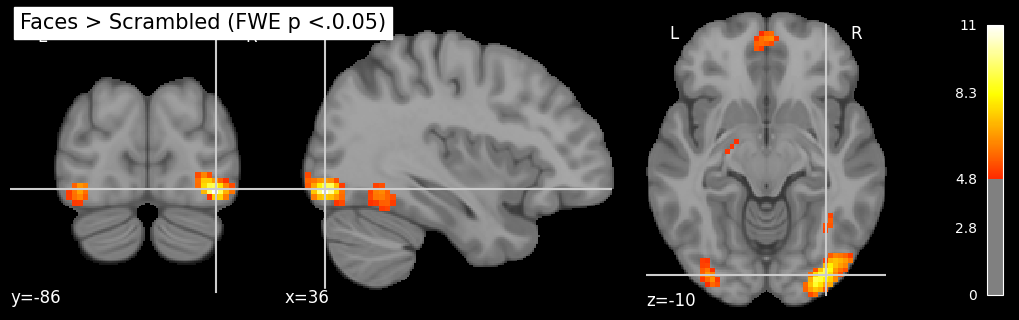

In [18]:
# Get the smallest t-value that is above the threshold (for the colorbar; the maps themselves are thresholded already)
threshold_fwe = masked_t_map[masked_t_map > 0].min()
print('FWE (perm.) p<.05 threshold: %.3f' % threshold_fwe)

plot_stat_map(
    masked_t_map_img, 
    threshold = threshold_fwe,       
    display_mode = 'ortho',
    black_bg = True,
    bg_img = mni152_template,
    cmap = 'hot',
    title = f"Faces > Scrambled (FWE p <.{alpha})")

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

In this example, we observe that the non-parametric FWE correction is slightly less conservative than the Bonferroni correction.

We will save the thresholded image for later use in our [Region of Interest (ROI) tutorial](nb06_ROI_analysis.ipynb).

In [19]:
nib.save(masked_t_map_img, os.path.join(fmri_group_dir, 'FacesScrambled_fwe_t-map.nii.gz'))

## Summary results

### Using atlasreader package

We can use ['atlasreader'](https://github.com/miykael/atlasreader) package to get summary results (peak table, cluster table, .png images of each cluster). 

In [20]:
# generate and save atlasreader output
outdir = os.path.join(fmri_results_dir, 'group-level', 'permutation', 'FacesScrambled')

create_output(
    masked_t_map_img, 
    cluster_extent = 20, 
    voxel_thresh = threshold_fwe,
    direction = 'pos',
    outdir = outdir
)

/imaging/correia/da05/conda/env/mriworkshops/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/imaging/correia/da05/conda/env/mriworkshops/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)


In [21]:
# display the peak table
peaks = glob.glob(os.path.join(outdir, '*_peaks.csv'))
display(pd.read_csv(peaks[0]))

cluster_id  peak_x  peak_y  peak_z  peak_value  volume_mm  \
0         1.0    36.0   -87.0   -12.0   11.132135     5643.0   
1         2.0   -42.0   -57.0   -18.0    8.140448     4320.0   
2         3.0    42.0   -54.0   -18.0    9.263475     3780.0   
3         4.0    -6.0    51.0   -12.0    6.665463     1539.0   
4         5.0    45.0   -57.0    12.0    6.494235     1458.0   
5         6.0    21.0    -9.0   -15.0    7.043221     1026.0   
6         7.0   -21.0    -9.0   -15.0    7.528140      621.0   

                 aal             desikan_killiany  \
0    Occipital_Inf_R  Right-Cerebral-White-Matter   
1         Fusiform_L              ctx-lh-fusiform   
2         Fusiform_R              ctx-rh-fusiform   
3  Frontal_Med_Orb_L                      Unknown   
4     Temporal_Mid_R      ctx-rh-lateraloccipital   
5      Hippocampus_R               Right-Amygdala   
6         Amygdala_L                Left-Amygdala   

                                      harvard_oxford  
0  44.0% Right_Lateral_Occipital_Cortex_inferior_...  
1  51.0% Left_Temporal_Occipital_Fusiform_Cortex;...  
2     65.0% Right_Temporal_Occipital_Fusiform_Cortex  
3  70.0% Left_Frontal_Medial_Cortex; 10.0% Left_F...  
4  44.0% Right_Middle_Temporal_Gyrus_temporooccip...  
5      78.0% Right_Amygdala; 12.0% Right_Hippocampus  
6                                91.0% Left_Amygdala

In [22]:
# display the cluster table
clusters = glob.glob(os.path.join(outdir, '*_clusters.csv'))
display(pd.read_csv(clusters[0]))

cluster_id  peak_x  peak_y  peak_z  cluster_mean  volume_mm  \
0         1.0    36.0   -87.0   -12.0      6.533613     5643.0   
1         2.0   -42.0   -57.0   -18.0      5.909559     4320.0   
2         3.0    42.0   -54.0   -18.0      6.237574     3780.0   
3         4.0    -6.0    51.0   -12.0      5.573177     1539.0   
4         5.0    45.0   -57.0    12.0      5.397290     1458.0   
5         6.0    21.0    -9.0   -15.0      5.506311     1026.0   
6         7.0   -21.0    -9.0   -15.0      5.768715      621.0   

                                                 aal  \
0            83.25% Occipital_Inf_R; 5.74% Lingual_R   
1  57.50% Fusiform_L; 22.50% Occipital_Inf_L; 10....   
2  67.14% Fusiform_R; 20.00% Temporal_Inf_R; 5.71...   
3  49.12% Frontal_Med_Orb_L; 21.05% Rectus_L; 19....   
4       92.59% Temporal_Mid_R; 7.41% Occipital_Mid_R   
5  63.16% Hippocampus_R; 31.58% Amygdala_R; 5.26%...   
6  52.17% Hippocampus_L; 34.78% Amygdala_L; 13.04...   

                                    desikan_killiany  \
0  43.06% Right-Cerebral-White-Matter; 38.28% ctx...   
1  25.62% ctx-lh-fusiform; 24.38% Left-Cerebral-W...   
2  38.57% ctx-rh-fusiform; 37.14% Right-Cerebral-...   
3  68.42% Unknown; 22.81% ctx-lh-medialorbitofron...   
4  40.74% Right-Cerebral-White-Matter; 22.22% ctx...   
5  57.89% Right-Amygdala; 18.42% Right-Hippocampu...   
6  56.52% Left-Amygdala; 21.74% Left-Hippocampus;...   

                                      harvard_oxford  
0  66.51% Right_Lateral_Occipital_Cortex_inferior...  
1  37.50% Left_Temporal_Occipital_Fusiform_Cortex...  
2  82.86% Right_Temporal_Occipital_Fusiform_Corte...  
3  38.60% Left_Frontal_Medial_Cortex; 28.07% Righ...  
4  40.74% Right_Lateral_Occipital_Cortex_superior...  
5    78.95% Right_Amygdala; 21.05% Right_Hippocampus  
6      78.26% Left_Amygdala; 17.39% Left_Hippocampus

**Some more plotting options**

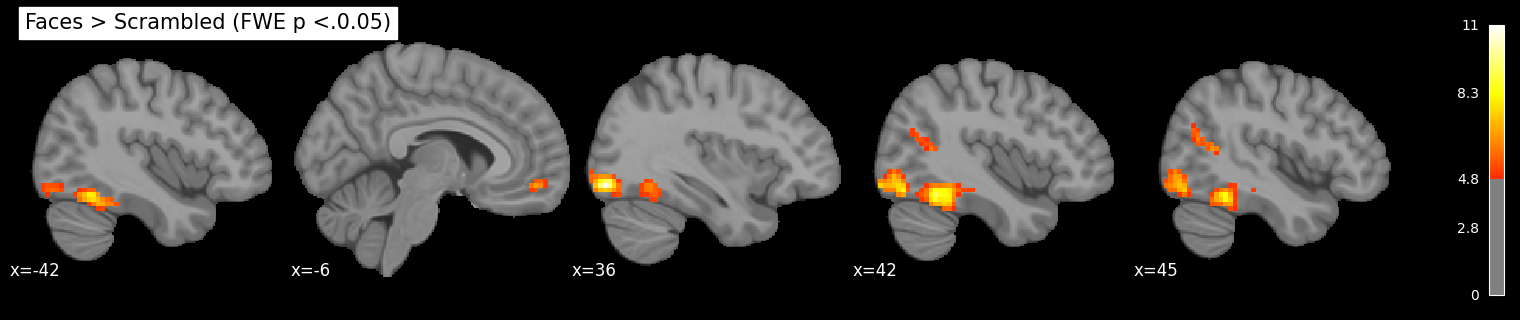

In [23]:
# get the top 5 peaks' x values
x = pd.read_csv(peaks[0])['peak_x'][:5]
# sort the x values
x = x.sort_values()

# plot these peaks
plot_stat_map(
    masked_t_map_img, 
    threshold = threshold_fwe,       
    display_mode = 'x',
    cut_coords = x,
    black_bg = True,
    bg_img = mni152_template,
    cmap = 'hot',
    title = f"Faces > Scrambled (FWE p <.{alpha})")

fig = plt.gcf()
fig.set_size_inches(15,3)

We can also look at a 3D brain using `plotly`.

In [24]:
view = view_img_on_surf(masked_t_map_img, 
    threshold = threshold_fwe)
#view.open_in_browser()
view.resize(1600, 800)
view

/tmp/ipykernel_1369647/2970978110.py:1: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  view = view_img_on_surf(masked_t_map_img,


Or use, for example, FSLeyes to plot and explore the result maps. 

### Nilearn's report

Nilearn has a built-in report generator that can create reports for all defined contrasts. However, a limitation is that it cannot generate reports for results obtained using non-parametric inference.

In [25]:
second_level_report = second_level_model.generate_report(
  contrasts, 
  title = "Results of the second-level analysis", 
  bg_img = mni152_template, 
  alpha = 0.001, 
  cluster_threshold = 20, 
  height_control = 'fpr', 
  min_distance = 8.0, 
  plot_type = 'slice', 
  display_mode = 'x', 
  report_dims = (1600, 800))

second_level_report.open_in_browser()

#second_level_report.save_as_html(file_name)

/tmp/ipykernel_1369647/3627742304.py:1: UserWarning: The given float value must not exceed 0.0. But, you have given threshold=3.2905267314918945.
  second_level_report = second_level_model.generate_report(
/tmp/ipykernel_1369647/3627742304.py:1: UserWarning: Attention: No clusters with stat higher than 3.2905267314918945
  second_level_report = second_level_model.generate_report(


## 🧠 EXERCISE

Perform a one-sample t-test on the first-level results of *Faces > Scrambled* contrast. How do the results compare to our ANOVA model approach above? 

In [26]:
# Retrieve the first-level effect maps for the contrast


# Display subject level maps


# Create a design matrix 


# Specify and fit the second-level model


# Compute the contrast and get the z-map


# Threshold the z-map


# Display the thresholded map

